# Baseline CNN Model for Movement Classification
## 1D Convolutional Neural Networks for Neural Spike Data

**Authors:** Daniel Katz & Roi Wayner  
**Course:** Deep Learning for Physiological Signals (3360209)  
**Date:** 2025

---

## 📖 Notebook Overview

This notebook implements **baseline CNN models** for movement classification using neural spike data from Rhesus monkey motor cortex recordings. We explore 1D convolutional architectures to decode 12 different digit/wrist movements from neural activity.

### Key Objectives:
1. **Implement 1D CNN architectures** for neural spike classification
2. **Compare with logistic regression baselines** for performance benchmarking
3. **Evaluate temporal feature extraction** through convolutional layers
4. **Assess cross-subject generalization** (Chip → Gabby transfer)
5. **Analyze model performance** across different movement classes

### Model Architectures:
- **Logistic Regression**: Flattened feature baseline
- **1D CNN**: Temporal convolutional feature extraction
- **ResNet-style CNN**: Residual connections for deeper networks
- **Cross-subject evaluation**: Train on Chip, test on Gabby

### Data:
- **Chip Dataset**: 152 neurons, temporal window [200:800] = 600 timesteps
- **Movement Classes**: 12 digit/wrist flexion/extension movements
- **Train/Validation/Test**: Standard splits for robust evaluation

---

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import wfdb

from tqdm import tqdm
# import torchviz

In [4]:
x =  np.load(r"dataset\Chip\train_500\X_long.npy")
y = np.load(r"dataset\Chip\train_500\y_long.npy")


x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")

x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

x = x[:,:,200:800]
x_val = x_val[:,:,200:800]
x_test = x_test[:,:,200:800]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')



X shape: (6000, 152, 600) y shape: (6000,)
X_val shape: (600, 152, 600) y_val shape: (600,)
X_test shape: (600, 152, 600) y_test shape: (600,)


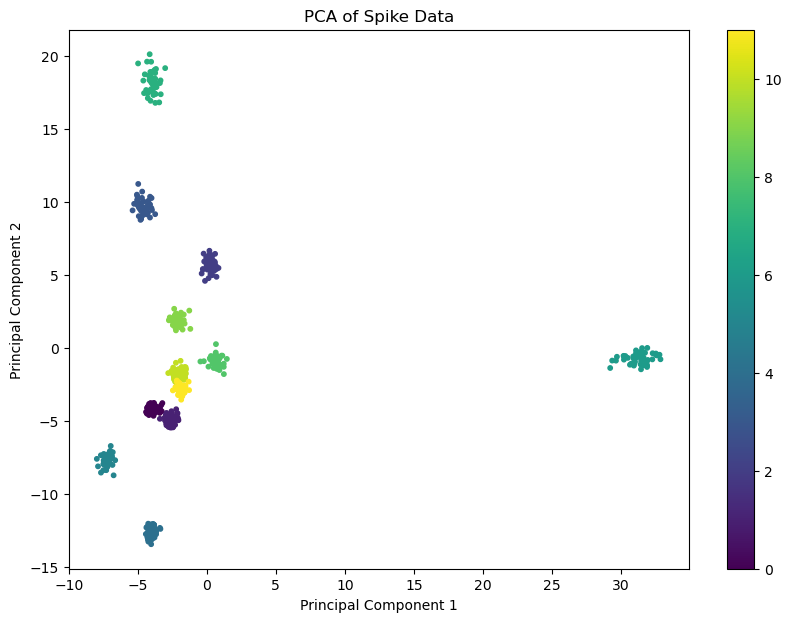

Validation Accuracy: 0.9167
Test Accuracy: 0.9167
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.50      1.00      0.67        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.00      0.00      0.00        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50

    accuracy                           0.92       600
   macro avg       0.88      0.92      0.89       600
weighted avg       0.88      0.92      0.89       600

Test Classification Report:
              precisi

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

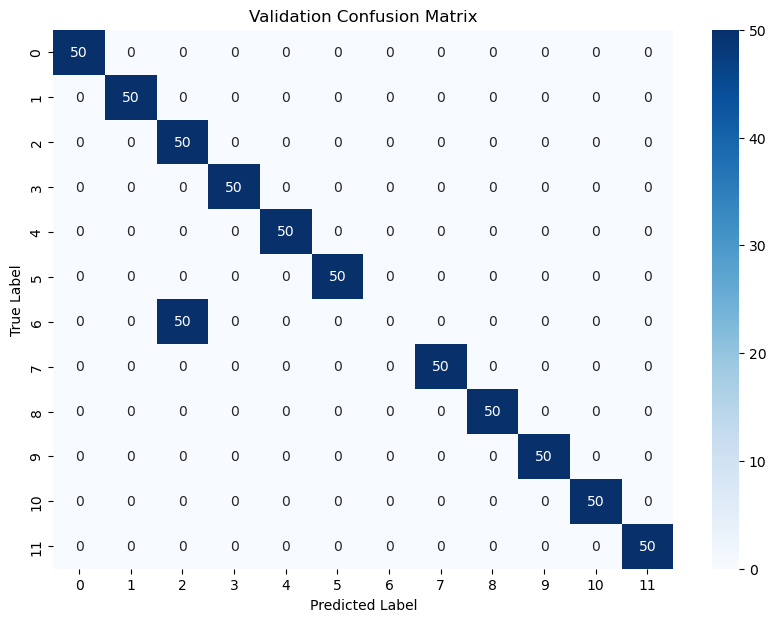

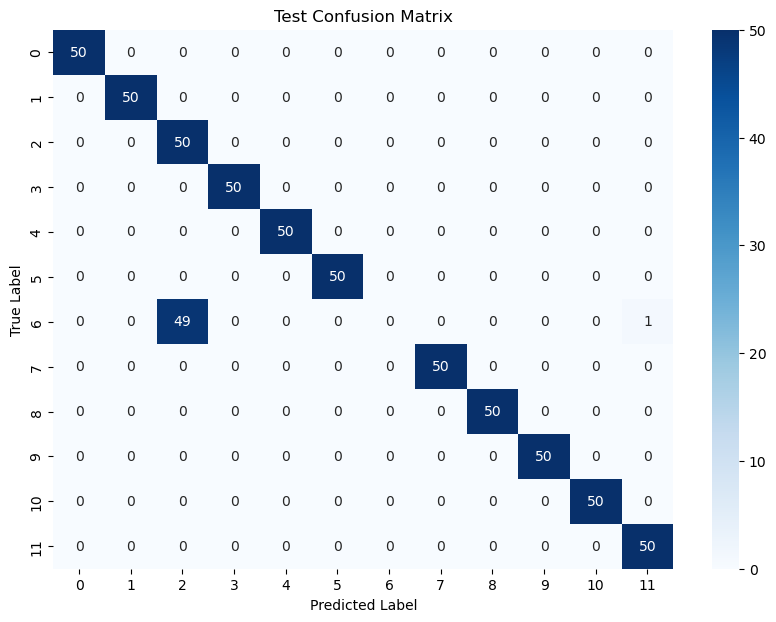

Training Cross-Entropy Loss: 0.0010
Validation Cross-Entropy Loss: 1.2392
Test Cross-Entropy Loss: 1.2380


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten x_val for logistic regression: [samples, neurons, time] -> [samples, neurons*time]
X_flat = x.reshape(x.shape[0], -1)
X_flat_val = x_val.reshape(x_val.shape[0], -1)
X_flat_test = x_test.reshape(x_test.shape[0], -1)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=10)
plt.title('PCA of Spike Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_flat, y)
# Make predictions on the validation set
y_pred_val = log_reg.predict(X_flat_val)
# Make predictions on the test set
y_pred_test = log_reg.predict(X_flat_test)

# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')

# Print confusion matrix
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# calculate loss with croos entropy
loss_function = nn.CrossEntropyLoss()
# Calculate cross-entropy loss for validation and test sets

# Convert predictions and true labels to tensors
y_train_tensor = torch.tensor(y, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
# For cross-entropy, need logits (not probabilities), so use decision_function or predict_proba
train_logits = torch.tensor(log_reg.decision_function(X_flat), dtype=torch.float32)
val_logits = torch.tensor(log_reg.decision_function(X_flat_val), dtype=torch.float32)
test_logits = torch.tensor(log_reg.decision_function(X_flat_test), dtype=torch.float32)

train_loss = loss_function(train_logits, y_train_tensor).item()
val_loss = loss_function(val_logits, y_val_tensor).item()
test_loss = loss_function(test_logits, y_test_tensor).item()
print(f'Training Cross-Entropy Loss: {train_loss:.4f}')
print(f'Validation Cross-Entropy Loss: {val_loss:.4f}')
print(f'Test Cross-Entropy Loss: {test_loss:.4f}')



2


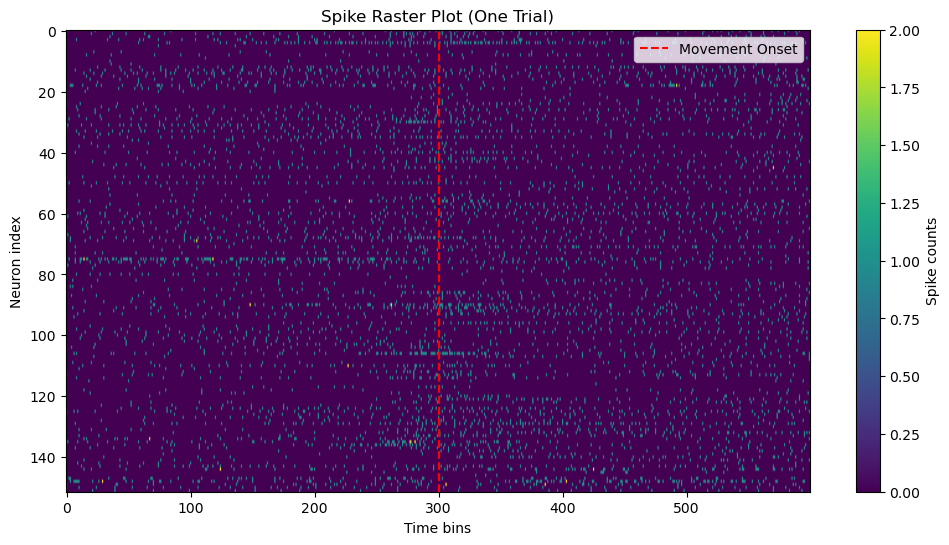

In [263]:
# plot first trail for all neurons
i = 100
plt.figure(figsize=(12, 6))
print(y_test[i])
plt.imshow(x[i], aspect='auto', cmap='viridis')
plt.colorbar(label='Spike counts')
plt.axvline(x=300, color='red', linestyle='--', label='Movement Onset')
plt.legend()
plt.xlabel('Time bins')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot (One Trial)')
plt.show()

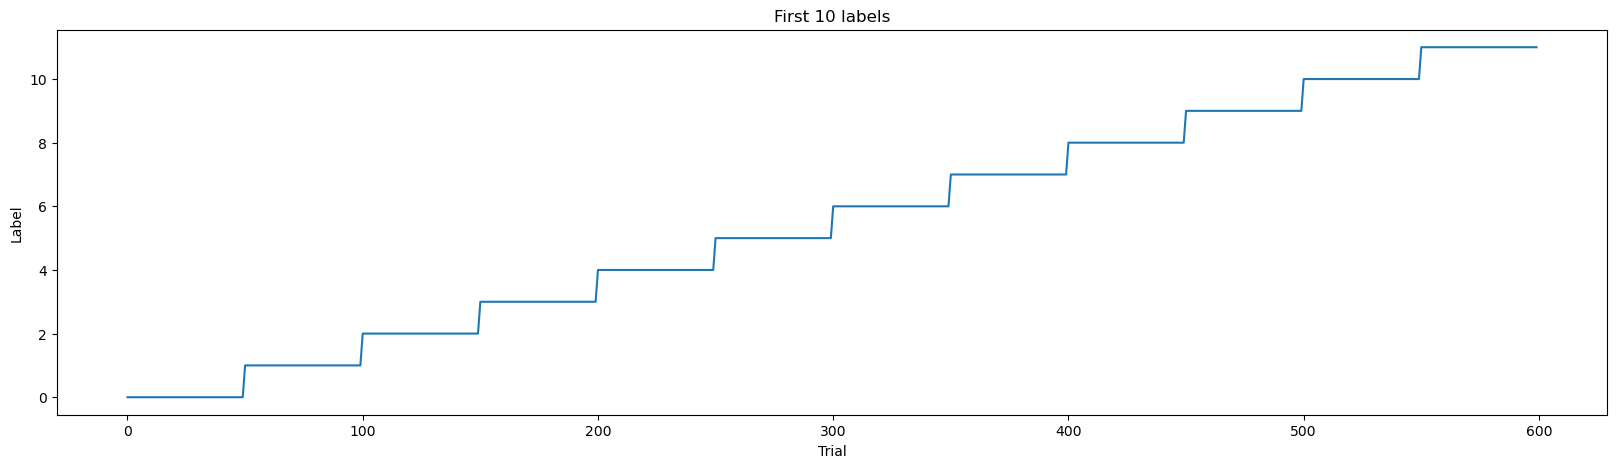

Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f


In [264]:
# plot the labels
plt.figure(figsize=(20, 5))
plt.plot(y[:])
plt.title('First 10 labels')
plt.xlabel('Trial')
plt.ylabel('Label')
plt.show()
print('Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f')

In [5]:
# transform the signal into a PyTorch tensor
class Ntransform(object):
    """
    This will transform the ECG signal into a PyTorch tensor. This is the place to apply other transformations as well, e.g., normalization, etc.
    """
    def __call__(self, signal):
        # Transform the data type from double (float64) to single (float32) to match the later network weights.
        t_signal = torch.from_numpy(signal).float()
        # We transpose the signal to later use the lead dim as the channel... (C,L).
        t_signal = t_signal.permute(1, 0)
        return t_signal  # Make sure I am a PyTorch Tensor

In [6]:
# Create a custom dataset class
class NeuronalDataset(Dataset):
    def __init__(self, signals_array, labels_array, transform=None):
        """
        Args:
            signals_array: np.ndarray, shape (N, T, C) -- neuronal activity
            labels_array: np.ndarray, shape (N,)        -- labels for samples
            transform: optional callable to transform signals
        """
        super().__init__()
        self.signals = signals_array
        self.labels = labels_array
        self.transform = transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]

        if self.transform:
            signal = self.transform(signal)

        signal = signal.detach().clone().float()
        label = torch.tensor(label, dtype=torch.long)  #classification

        return signal, label

    def __len__(self):
        return len(self.signals)

In [7]:
batch_size = 4
num_workers = 0

#train dataset
x = np.transpose(x, (0, 2, 1))
sampler = np.arange(x.shape[0])
train_sampler = SubsetRandomSampler(sampler)
train_dataset = NeuronalDataset(x, y, transform=Ntransform())
dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

#train validation dataset
x_val = np.transpose(x_val, (0, 2, 1))
sampler = np.arange(x_val.shape[0])
val_sampler = SubsetRandomSampler(sampler)
val_dataset = NeuronalDataset(x_val, y_val, transform=Ntransform())
dl_val = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

#test dataset
x_test = np.transpose(x_test, (0, 2, 1))
sampler = np.arange(x_test.shape[0])
test_sampler = SubsetRandomSampler(sampler)
test_dataset = NeuronalDataset(x_test, y_test, transform=Ntransform())
dl_test = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)




In [123]:

import torch.nn.functional as F

# Define a single Residual Block with Dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.6):
        super().__init__()
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=61, padding=30),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(in_channels, in_channels, kernel_size=81, padding=40),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# ResidualNet1D with Dropout in initial and residual blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob)
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [124]:
net = ResidualNet1D(152, num_classes=12)  # notice that we defined it in a way that the batch-size does not play a role, yet it needs to be included in the tensor shape.
print(net)

ResidualNet1D(
  (initial): Sequential(
    (0): Conv1d(152, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(61,), stride=(1,), padding=(30,))
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Conv1d(16, 16, kernel_size=(81,), stride=(1,), padding=(40,))
        (4): ReLU()
        (5): Dropout(p=0.3, inplace=False)
      )
      (skip_layers): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(61,), stride=(1,), padding=(30,))
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Conv1d(16, 16, kernel_size=(81,), stride=(1,), padding=(40,))
        (4): ReLU()
        (5

In [125]:
# Define the model, loss function, and optimizer
loss_function = nn.CrossEntropyLoss()
# num param
print(sum(p.numel() for p in net.parameters()))

learning_rate = 0.0001

optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)


200556


In [64]:
def forward_epoch(model, dl, loss_function, optimizer, train_mode=True, desc=None, device=torch.device('cpu') , shuffle=False):
    total_loss = 0

    with tqdm(total=len(dl), desc=desc, ncols=100) as pbar:
        for i_batch, (X, y) in enumerate(dl):
            # if not train_mode and i_batch >= len(dl) // 3:
            #     break  # Process only half of the dataloader in evaluation mode
            
            if shuffle:
                # Randomly shuffle the channels on X
                X = X[:, torch.randperm(X.size(1)), :]
            X = X.to(device)
            y = y.to(device)

            # Forward:
            y_pred = model(X)  # [batch, num_classes]

            y_true = y.type(torch.float32)
            # print(f'y_pred.shape = {y_pred.shape}')
            # print(f'y_true = {y_true}')
            # print(f'y_true unique = {torch.unique(y_true)}')
            loss = loss_function(y_pred, y_true.long())

            total_loss += loss.item()

            if train_mode:  # Don't enter the gradient updating steps if not training.
                # Backward:
                optimizer.zero_grad()  # zero the gradients to not accumulate their changes.
                loss.backward()  # get gradients

                # Optimization step:
                optimizer.step()  # use gradients

            # Store y vectors over the epoch:
            if i_batch == 0:
                y_true_epoch = y_true
                y_pred_epoch = y_pred
            else:
                y_true_epoch = torch.concat((y_true_epoch, y_true))
                y_pred_epoch = torch.concat((y_pred_epoch, y_pred))

            # Progress bar:
            pbar.update(1)

    return total_loss, y_true_epoch, y_pred_epoch



In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , shuffled = False,  title = False):

    with torch.no_grad():
        train_set_loss, y_true_train, y_pred_train = forward_epoch(
            net, dl_train, loss_function, optimizer, train_mode=False, desc='Train', device=device , shuffle=shuffled)
        val_loss, y_true_val, y_pred_val = forward_epoch(
            net, dl_val, loss_function, optimizer, train_mode=False, desc='Val', device=device , shuffle=shuffled)
        test_loss, y_true_test, y_pred_test = forward_epoch(
            net, dl_test, loss_function, optimizer, train_mode=False, desc='Test', device=device , shuffle=shuffled)

    train_loss = train_set_loss / len(dl_train)
    train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
    val_loss = val_loss / len(dl_val)
    val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))
    test_loss = test_loss / len(dl_test)
    test_accuracy = accuracy_score(y_true_test.cpu(), y_pred_test.cpu().detach().argmax(dim=1))

    print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \n '
          f'Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)} \n'
          f'Test_loss={round(test_loss, 3)}; Test_accuracy={round(test_accuracy, 3)} \n')

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    if title:
        fig.suptitle(title, fontsize=17)
    else:
        fig.suptitle('Confusion Matrices', fontsize=17 )

    cm_train = confusion_matrix(y_true_train.cpu().numpy(), y_pred_train.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_title('Train' , fontsize=16 , y =1.16)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[0].text(0.0, 1.06, f'Overall Accuracy: {train_accuracy:.2f}', ha='left', va='center', transform=axs[0].transAxes)
    axs[0].text(0.0, 1.15, f'Overall Loss: {train_loss:.2f}', ha='left', va='center', transform=axs[0].transAxes)

    cm_val = confusion_matrix(y_true_val.cpu().numpy(), y_pred_val.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_title('Validation' , fontsize=16 , y =1.16)
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')
    axs[1].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[1].text(0.0, 1.06, f'Overall Accuracy: {val_accuracy:.2f}', ha='left', va='center', transform=axs[1].transAxes)
    axs[1].text(0.0, 1.15, f'Overall Loss: {val_loss:.2f}', ha='left', va='center', transform=axs[1].transAxes)

    cm_test = confusion_matrix(y_true_test.cpu().numpy(), y_pred_test.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[2])
    axs[2].set_title('Test' , fontsize=16 , y =1.16)
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    axs[2].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[2].text(0.0, 1.06, f'Overall Accuracy: {test_accuracy:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    axs[2].text(0.0, 1.15, f'Overall Loss: {test_loss:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()


# # test
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance')



In [49]:
%matplotlib inline

print("torch version: ", torch.__version__)
print("torch cuda: ", torch.cuda.is_available())
print("torch cuda version: ", torch.version.cuda)
print("torch cuda device count: ", torch.cuda.device_count())
print("torch cuda device name: ", torch.cuda.get_device_name())
print("torch cuda current device: ", torch.cuda.current_device())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clear cache
torch.cuda.empty_cache()

epochs = 50

train_loss_vec = []
val_loss_vec = []
train_accuracy_vec = []
val_accuracy_vec = []
best_val_loss = float('inf')
best_val_accuracy = 0
lr_vec = []

print(device)
net = net.to(device)  # Move the model to GPU if available

for i_epoch in range(epochs):
    print(f'Epoch: {i_epoch + 1}/{epochs}')

    net.train()  # model should be on train mode --> layers like Batch normalization and dropout will be affected.
    train_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer, train_mode=True,
                                                           desc='Train', device=device )
    if i_epoch % 1 == 0:
        net.eval()  # model should be on evaluation mode.
        # run train assessment to see how the model is doing.
        
        with torch.no_grad():  # Evaluation mode; thus, tell the model that we don't want gradients to be kept for updating (this will speed computation and save memory).
            print(f'epoch {i_epoch}')
            train_set_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer,
                                                                train_mode=False, desc='Train', device=device)
            val_loss, y_true_val, y_pred_val = forward_epoch(net, dl_val, loss_function, optimizer,
                                                                train_mode=False, desc='Val', device=device)

        # Metrics:
        train_loss = train_loss / len(dl_train)  # we want to get the mean over batches.
        train_loss_vec.append(train_loss)
        train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
        val_loss = val_loss / len(dl_val)
        val_loss_vec.append(val_loss)
        val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))

        train_accuracy_vec.append(train_accuracy)
        val_accuracy_vec.append(val_accuracy)

        print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \
            Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)}')
        
        # save checkpoint 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(), r'model_weights\model1\best_val_loss_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation loss: {val_loss:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(net.state_dict(), r'model_weights\model1\best_val_accuracy_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation accuracy: {val_accuracy:.4f}")

    lr_vec.append(optimizer.param_groups[0]['lr'])
    lr_scheduler.step()  # update the learning rate according to the schedule.
# save the last checkpoint
torch.save(net.state_dict(), fr'model_weights\model1\last_cp_e{i_epoch+1}.pth')



torch version:  2.4.0+cu121
torch cuda:  True
torch cuda version:  12.1
torch cuda device count:  1
torch cuda device name:  NVIDIA GeForce RTX 4090
torch cuda current device:  0
cuda
Epoch: 1/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 207.30it/s]


epoch 0


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 538.56it/s]

Train_loss=2.494; Train_accuracy=0.083             Validation_loss=2.494; Validation_accuracy=0.083


RuntimeError: Parent directory model_weights\model1 does not exist.

# PLOT TRAINING AND EVALUATION

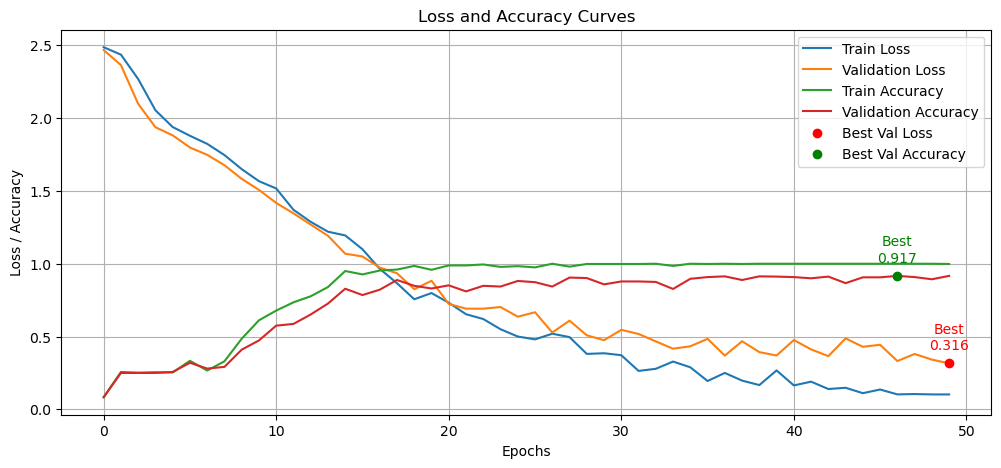

C:\Users\cathalert\AppData\Local\Temp\ipykernel_19044\2936860026.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(fr'model_weights\model1\

Train_loss=0.019; Train_accuracy=0.998 
 Validation_loss=0.316; Validation_accuracy=0.917 
Test_loss=0.409; Test_accuracy=0.852 



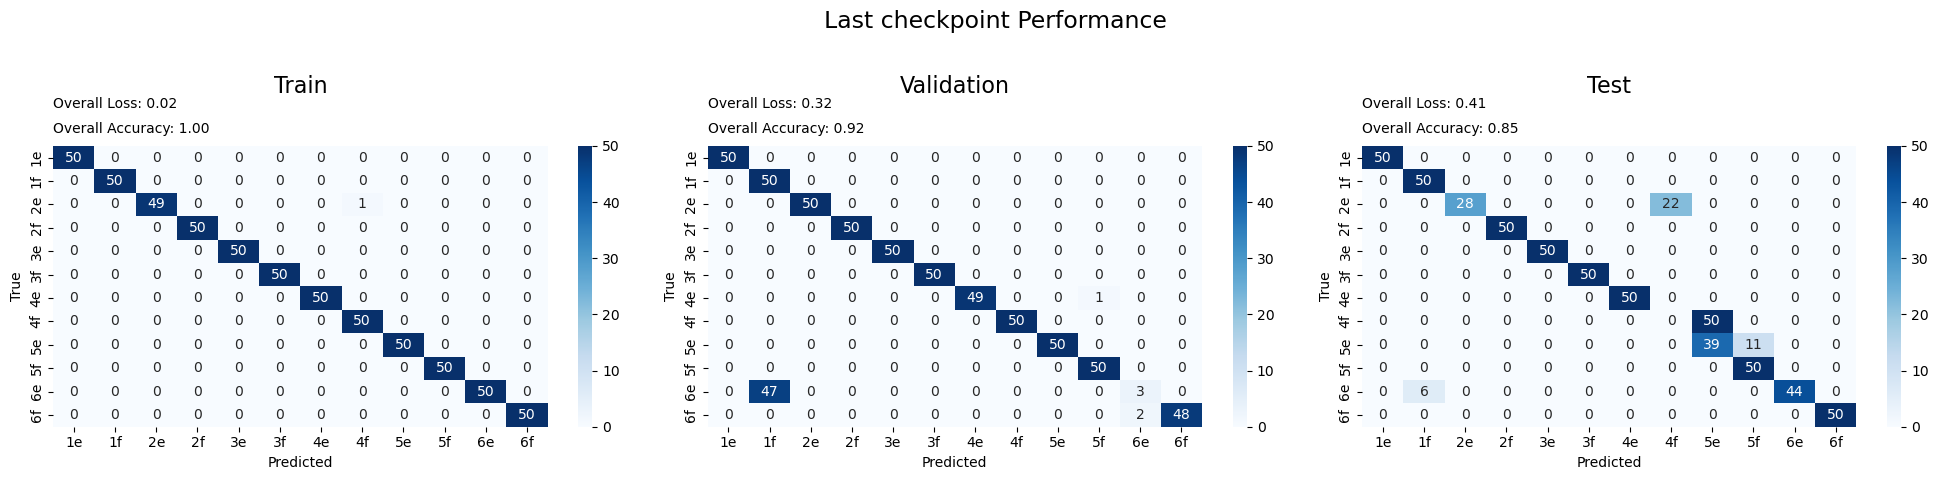

C:\Users\cathalert\AppData\Local\Temp\ipykernel_19044\2936860026.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r'model_weights\model1\b

Train_loss=0.019; Train_accuracy=0.998 
 Validation_loss=0.316; Validation_accuracy=0.917 
Test_loss=0.409; Test_accuracy=0.852 



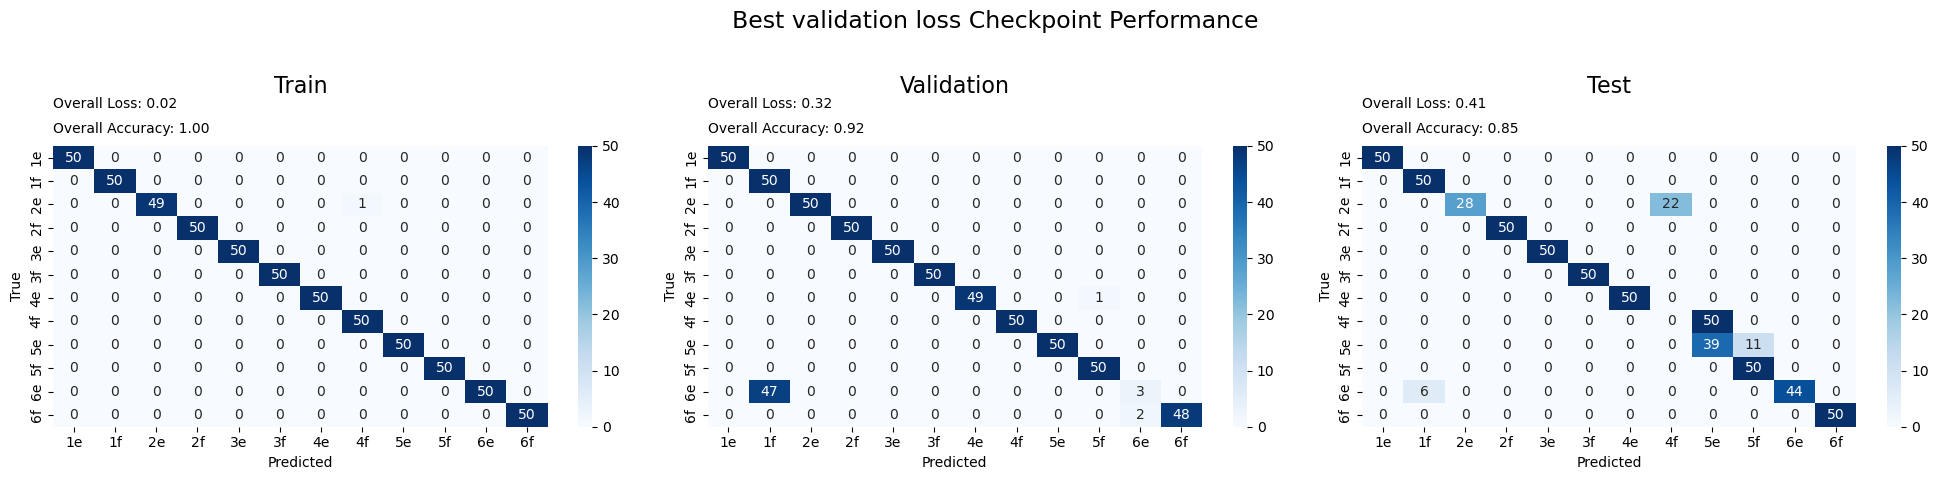

C:\Users\cathalert\AppData\Local\Temp\ipykernel_19044\2936860026.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r'model_weights\model1\b

Train_loss=0.019; Train_accuracy=1.0 
 Validation_loss=0.332; Validation_accuracy=0.917 
Test_loss=0.281; Test_accuracy=0.913 



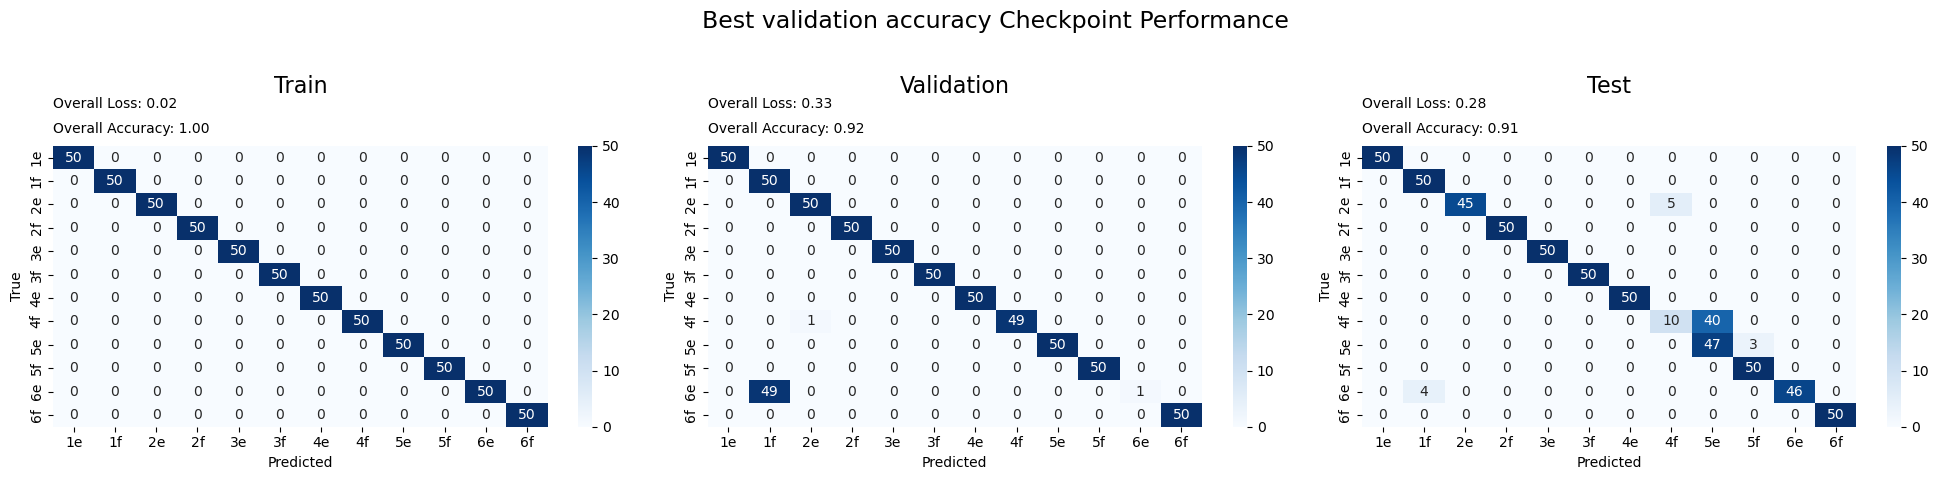

In [ ]:

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.plot(train_loss_vec, label='Train Loss')
plt.plot(val_loss_vec, label='Validation Loss')
plt.plot(train_accuracy_vec, label='Train Accuracy')
plt.plot(val_accuracy_vec, label='Validation Accuracy')
plt.plot([l*1000 for l in lr_vec], label='Learning Rate')

# Mark the best validation loss point
if len(val_loss_vec) > 0:
    best_epoch = np.argmin(val_loss_vec)
    plt.scatter(best_epoch, val_loss_vec[best_epoch], color='orange', zorder=5, label='Best Val Loss')
    plt.annotate(f'Best\n{val_loss_vec[best_epoch]:.3f}', 
                 (best_epoch, val_loss_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='orange')
# Mark the best validation accuracy point
if len(val_accuracy_vec) > 0:
    best_epoch = np.argmax(val_accuracy_vec)
    plt.scatter(best_epoch, val_accuracy_vec[best_epoch], color='red', zorder=5, label='Best Val Accuracy')
    plt.annotate(f'Best\n{val_accuracy_vec[best_epoch]:.3f}', 
                 (best_epoch, val_accuracy_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title('Loss and Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid()
plt.show()

labels = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']

# load the last checkpoint
net.load_state_dict(torch.load(fr'model_weights\model1\last_cp_e{i_epoch+1}.pth'))
net.eval()
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance')
# check the best validation loss

# load the loss best model
net.load_state_dict(torch.load(r'model_weights\model1\best_val_loss_cp.pth'))
net.eval()
# evaluate on the test set
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation loss Checkpoint Performance')

# load the acc best model
net.load_state_dict(torch.load(r'model_weights\model1\best_val_accuracy_cp.pth'))
net.eval()
# evaluate on the test set
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation accuracy Checkpoint Performance')


In [ ]:
# latent space after each block
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

movement_list = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']

def get_latent_space(model, dataloader, device):
    model.eval()
    all_latents = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            # Get output after each block
            x0 = model.initial(X)
            x1 = model.res_blocks[0](x0)
            x2 = model.res_blocks[1](x1)
            x3 = model.res_blocks[2](x2)
            pooled0 = model.pool(x0).squeeze(-1).cpu().numpy()
            pooled1 = model.pool(x1).squeeze(-1).cpu().numpy()
            pooled2 = model.pool(x2).squeeze(-1).cpu().numpy()
            pooled3 = model.pool(x3).squeeze(-1).cpu().numpy()
            all_latents.append({
                'initial': pooled0,
                'block1': pooled1,
                'block2': pooled2,
                'block3': pooled3
            })
            all_labels.append(y.cpu().numpy())
    # Concatenate results
    latents = {
        'initial': np.concatenate([d['initial'] for d in all_latents], axis=0),
        'block1': np.concatenate([d['block1'] for d in all_latents], axis=0),
        'block2': np.concatenate([d['block2'] for d in all_latents], axis=0),
        'block3': np.concatenate([d['block3'] for d in all_latents], axis=0),
    }
    labels = np.concatenate(all_labels, axis=0)
    return latents, labels

# Get latent space

#load the best model
net.load_state_dict(torch.load(r'model_weights\model1\best_val_accuracy_cp.pth'))
latents, labels = get_latent_space(net, dl_val, device)
# Perform PCA
pca = PCA(n_components=2)
pca_initial = pca.fit_transform(latents['initial'])
pca_block1 = pca.fit_transform(latents['block1'])
pca_block2 = pca.fit_transform(latents['block2'])
pca_block3 = pca.fit_transform(latents['block3'])
# Plot PCA results in 2d as subplots
plt.figure(figsize=(20, 10))
titles = ['Initial Conv', 'After Block 1', 'After Block 2', 'After Block 3']
pca_results = [pca_initial, pca_block1, pca_block2, pca_block3]

for i, (title, pca_data) in enumerate(zip(titles, pca_results)):
    plt.subplot(2, 2, i+1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Add legend
    handles = []
    for j, label in enumerate(movement_list):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=scatter.cmap(j/len(movement_list)), markersize=10))
    plt.legend(handles=handles, title='Movement', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')
    plt.grid()
plt.tight_layout()
plt.show()


C:\Users\cathalert\AppData\Local\Temp\ipykernel_2712\2509464407.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r"model_weights\model1_do

RuntimeError: Error(s) in loading state_dict for ResidualNet1D:
	Missing key(s) in state_dict: "initial.1.weight", "initial.1.bias", "initial.1.running_mean", "initial.1.running_var", "res_blocks.3.direct_path.0.weight", "res_blocks.3.direct_path.0.bias", "res_blocks.3.direct_path.3.weight", "res_blocks.3.direct_path.3.bias", "res_blocks.3.skip_layers.weight", "res_blocks.3.skip_layers.bias", "res_blocks.4.direct_path.0.weight", "res_blocks.4.direct_path.0.bias", "res_blocks.4.direct_path.3.weight", "res_blocks.4.direct_path.3.bias", "res_blocks.4.skip_layers.weight", "res_blocks.4.skip_layers.bias". 
	Unexpected key(s) in state_dict: "initial.2.weight", "initial.2.bias", "initial.2.running_mean", "initial.2.running_var", "initial.2.num_batches_tracked". 
	size mismatch for res_blocks.0.direct_path.0.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 61]).
	size mismatch for res_blocks.0.direct_path.3.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 81]).
	size mismatch for res_blocks.1.direct_path.0.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 61]).
	size mismatch for res_blocks.1.direct_path.3.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 81]).
	size mismatch for res_blocks.2.direct_path.0.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 61]).
	size mismatch for res_blocks.2.direct_path.3.weight: copying a param with shape torch.Size([16, 16, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 81]).

# Shuffled Data

In [126]:
net = ResidualNet1D(152, num_classes=12)  
# Define the model, loss function, and optimizer
loss_function = nn.CrossEntropyLoss()
# num param
print(sum(p.numel() for p in net.parameters()))

learning_rate = 0.0001

optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2.5, gamma=0.8)


200556


In [127]:
%matplotlib inline

print("torch version: ", torch.__version__)
print("torch cuda: ", torch.cuda.is_available())
print("torch cuda version: ", torch.version.cuda)
print("torch cuda device count: ", torch.cuda.device_count())
print("torch cuda device name: ", torch.cuda.get_device_name())
print("torch cuda current device: ", torch.cuda.current_device())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clear cache
torch.cuda.empty_cache()

epochs = 50

train_loss_vec = []
val_loss_vec = []
train_accuracy_vec = []
val_accuracy_vec = []
best_val_loss = float('inf')
best_val_accuracy = 0
lr_vec = []

print(device)
net = net.to(device)  # Move the model to GPU if available

for i_epoch in range(epochs):
    print(f'Epoch: {i_epoch + 1}/{epochs}')

    net.train()  # model should be on train mode --> layers like Batch normalization and dropout will be affected.
    train_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer, train_mode=True,
                                                           desc='Train', device=device , shuffle=True)
    if i_epoch % 1 == 0:
        net.eval()  # model should be on evaluation mode.
        # run train assessment to see how the model is doing.
        
        with torch.no_grad():  # Evaluation mode; thus, tell the model that we don't want gradients to be kept for updating (this will speed computation and save memory).
            print(f'epoch {i_epoch}')
            train_set_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer,
                                                                train_mode=False, desc='Train', device=device , shuffle=True)
            val_loss, y_true_val, y_pred_val = forward_epoch(net, dl_val, loss_function, optimizer,
                                                                train_mode=False, desc='Val', device=device , shuffle=True)

        # Metrics:
        train_loss = train_loss / len(dl_train)  # we want to get the mean over batches.
        train_loss_vec.append(train_loss)
        train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
        val_loss = val_loss / len(dl_val)
        val_loss_vec.append(val_loss)
        val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))

        train_accuracy_vec.append(train_accuracy)
        val_accuracy_vec.append(val_accuracy)

        print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \
            Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)}')
        
        # save checkpoint 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if not os.path.exists(r'model_weights\model1_shuffled'):
                os.makedirs(r'model_weights\model1_shuffled')
            torch.save(net.state_dict(), r'model_weights\model1_shuffled\best_val_loss_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation loss: {val_loss:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(net.state_dict(), r'model_weights\model1_shuffled\best_val_accuracy_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation accuracy: {val_accuracy:.4f}")
        
    lr_scheduler.step()
    lr_vec.append(lr_scheduler.get_last_lr()[0])
    
    if val_loss >11:
        print(f"Validation loss is too high, stopping training at epoch {i_epoch + 1}")
        break
    

# save the last checkpoint
torch.save(net.state_dict(), fr'model_weights\model1_shuffled\last_cp_e{i_epoch+1}.pth')



torch version:  2.4.0+cu121
torch cuda:  True
torch cuda version:  12.1
torch cuda device count:  1
torch cuda device name:  NVIDIA GeForce RTX 4090
torch cuda current device:  0
cuda
Epoch: 1/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:09<00:00, 165.46it/s]


epoch 0


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 442.48it/s]


Train_loss=2.392; Train_accuracy=0.223             Validation_loss=2.362; Validation_accuracy=0.225
Model saved at epoch 1 with validation loss: 2.3621
Model saved at epoch 1 with validation accuracy: 0.2250
Epoch: 2/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.18it/s]


epoch 1


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 451.81it/s]


Train_loss=1.884; Train_accuracy=0.618             Validation_loss=2.497; Validation_accuracy=0.253
Model saved at epoch 2 with validation accuracy: 0.2533
Epoch: 3/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.77it/s]


epoch 2


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 476.19it/s]


Train_loss=1.005; Train_accuracy=0.892             Validation_loss=5.137; Validation_accuracy=0.283
Model saved at epoch 3 with validation accuracy: 0.2833
Epoch: 4/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 185.26it/s]


epoch 3


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 465.84it/s]


Train_loss=0.649; Train_accuracy=0.929             Validation_loss=3.323; Validation_accuracy=0.378
Model saved at epoch 4 with validation accuracy: 0.3783
Epoch: 5/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 184.72it/s]


epoch 4


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 445.88it/s]


Train_loss=0.56; Train_accuracy=0.945             Validation_loss=4.616; Validation_accuracy=0.315
Epoch: 6/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.06it/s]


epoch 5


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 431.03it/s]


Train_loss=0.486; Train_accuracy=0.957             Validation_loss=6.632; Validation_accuracy=0.283
Epoch: 7/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 184.69it/s]


epoch 6


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 432.28it/s]


Train_loss=0.429; Train_accuracy=0.945             Validation_loss=6.456; Validation_accuracy=0.315
Epoch: 8/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.97it/s]


epoch 7


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 470.22it/s]


Train_loss=0.378; Train_accuracy=0.913             Validation_loss=7.753; Validation_accuracy=0.188
Epoch: 9/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 177.55it/s]


epoch 8


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 473.18it/s]


Train_loss=0.357; Train_accuracy=0.959             Validation_loss=6.285; Validation_accuracy=0.402
Model saved at epoch 9 with validation accuracy: 0.4017
Epoch: 10/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.14it/s]


epoch 9


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 455.92it/s]


Train_loss=0.328; Train_accuracy=0.955             Validation_loss=5.8; Validation_accuracy=0.402
Epoch: 11/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.40it/s]


epoch 10


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 443.79it/s]


Train_loss=0.273; Train_accuracy=0.967             Validation_loss=5.95; Validation_accuracy=0.425
Model saved at epoch 11 with validation accuracy: 0.4250
Epoch: 12/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.66it/s]


epoch 11


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 441.18it/s]


Train_loss=0.28; Train_accuracy=0.976             Validation_loss=5.943; Validation_accuracy=0.397
Epoch: 13/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.84it/s]


epoch 12


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 445.10it/s]


Train_loss=0.243; Train_accuracy=0.956             Validation_loss=5.493; Validation_accuracy=0.425
Epoch: 14/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.42it/s]


epoch 13


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 462.96it/s]


Train_loss=0.241; Train_accuracy=0.983             Validation_loss=4.886; Validation_accuracy=0.41
Epoch: 15/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.68it/s]


epoch 14


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 460.12it/s]


Train_loss=0.239; Train_accuracy=0.986             Validation_loss=5.589; Validation_accuracy=0.407
Epoch: 16/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.11it/s]


epoch 15


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 431.69it/s]


Train_loss=0.213; Train_accuracy=0.989             Validation_loss=6.156; Validation_accuracy=0.395
Epoch: 17/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.69it/s]


epoch 16


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 441.18it/s]


Train_loss=0.188; Train_accuracy=0.983             Validation_loss=6.526; Validation_accuracy=0.428
Model saved at epoch 17 with validation accuracy: 0.4283
Epoch: 18/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.74it/s]


epoch 17


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 442.29it/s]


Train_loss=0.188; Train_accuracy=0.983             Validation_loss=5.947; Validation_accuracy=0.427
Epoch: 19/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.33it/s]


epoch 18


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 417.83it/s]


Train_loss=0.194; Train_accuracy=0.987             Validation_loss=5.153; Validation_accuracy=0.42
Epoch: 20/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 178.59it/s]


epoch 19


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 443.79it/s]


Train_loss=0.185; Train_accuracy=0.982             Validation_loss=5.632; Validation_accuracy=0.495
Model saved at epoch 20 with validation accuracy: 0.4950
Epoch: 21/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 178.96it/s]


epoch 20


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 426.14it/s]


Train_loss=0.173; Train_accuracy=0.989             Validation_loss=7.876; Validation_accuracy=0.39
Epoch: 22/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 179.16it/s]


epoch 21


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 462.96it/s]


Train_loss=0.155; Train_accuracy=0.988             Validation_loss=6.462; Validation_accuracy=0.457
Epoch: 23/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.05it/s]


epoch 22


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 438.60it/s]


Train_loss=0.154; Train_accuracy=0.983             Validation_loss=5.904; Validation_accuracy=0.465
Epoch: 24/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.55it/s]


epoch 23


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 455.93it/s]


Train_loss=0.158; Train_accuracy=0.986             Validation_loss=7.777; Validation_accuracy=0.405
Epoch: 25/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 179.03it/s]


epoch 24


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 464.40it/s]


Train_loss=0.143; Train_accuracy=0.987             Validation_loss=7.609; Validation_accuracy=0.44
Epoch: 26/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.71it/s]


epoch 25


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 466.51it/s]


Train_loss=0.147; Train_accuracy=0.988             Validation_loss=6.56; Validation_accuracy=0.458
Epoch: 27/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.50it/s]


epoch 26


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 457.31it/s]


Train_loss=0.13; Train_accuracy=0.989             Validation_loss=4.55; Validation_accuracy=0.505
Model saved at epoch 27 with validation accuracy: 0.5050
Epoch: 28/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.02it/s]


epoch 27


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 451.81it/s]


Train_loss=0.134; Train_accuracy=0.982             Validation_loss=6.251; Validation_accuracy=0.483
Epoch: 29/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.07it/s]


epoch 28


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 468.75it/s]


Train_loss=0.148; Train_accuracy=0.991             Validation_loss=5.624; Validation_accuracy=0.462
Epoch: 30/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.44it/s]


epoch 29


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 451.05it/s]


Train_loss=0.123; Train_accuracy=0.985             Validation_loss=3.828; Validation_accuracy=0.518
Model saved at epoch 30 with validation accuracy: 0.5183
Epoch: 31/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 176.77it/s]


epoch 30


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 453.17it/s]


Train_loss=0.127; Train_accuracy=0.989             Validation_loss=7.594; Validation_accuracy=0.438
Epoch: 32/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.06it/s]


epoch 31


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 432.80it/s]


Train_loss=0.133; Train_accuracy=0.977             Validation_loss=7.395; Validation_accuracy=0.455
Epoch: 33/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.34it/s]


epoch 32


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 434.79it/s]


Train_loss=0.115; Train_accuracy=0.99             Validation_loss=5.881; Validation_accuracy=0.485
Epoch: 34/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.42it/s]


epoch 33


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 455.08it/s]


Train_loss=0.124; Train_accuracy=0.99             Validation_loss=5.988; Validation_accuracy=0.472
Epoch: 35/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 178.67it/s]


epoch 34


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 450.45it/s]


Train_loss=0.129; Train_accuracy=0.991             Validation_loss=7.029; Validation_accuracy=0.43
Epoch: 36/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 183.59it/s]


epoch 35


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 433.69it/s]


Train_loss=0.11; Train_accuracy=0.992             Validation_loss=3.568; Validation_accuracy=0.502
Epoch: 37/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 179.64it/s]


epoch 36


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 458.72it/s]


Train_loss=0.119; Train_accuracy=0.991             Validation_loss=4.341; Validation_accuracy=0.483
Epoch: 38/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 179.64it/s]


epoch 37


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 464.52it/s]


Train_loss=0.111; Train_accuracy=0.991             Validation_loss=8.304; Validation_accuracy=0.442
Epoch: 39/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.48it/s]


epoch 38


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 468.75it/s]


Train_loss=0.112; Train_accuracy=0.99             Validation_loss=7.011; Validation_accuracy=0.462
Epoch: 40/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 185.11it/s]


epoch 39


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 455.93it/s]


Train_loss=0.103; Train_accuracy=0.987             Validation_loss=7.5; Validation_accuracy=0.415
Epoch: 41/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.19it/s]


epoch 40


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 458.72it/s]


Train_loss=0.102; Train_accuracy=0.988             Validation_loss=6.788; Validation_accuracy=0.443
Epoch: 42/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 184.41it/s]


epoch 41


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 446.43it/s]


Train_loss=0.104; Train_accuracy=0.99             Validation_loss=5.933; Validation_accuracy=0.482
Epoch: 43/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.03it/s]


epoch 42


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 427.36it/s]


Train_loss=0.103; Train_accuracy=0.99             Validation_loss=4.704; Validation_accuracy=0.497
Epoch: 44/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.98it/s]


epoch 43


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 437.32it/s]


Train_loss=0.107; Train_accuracy=0.991             Validation_loss=4.178; Validation_accuracy=0.51
Epoch: 45/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.95it/s]


epoch 44


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 453.17it/s]


Train_loss=0.094; Train_accuracy=0.979             Validation_loss=5.961; Validation_accuracy=0.49
Epoch: 46/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 184.17it/s]


epoch 45


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 458.72it/s]


Train_loss=0.094; Train_accuracy=0.986             Validation_loss=7.15; Validation_accuracy=0.475
Epoch: 47/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.12it/s]


epoch 46


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 459.80it/s]


Train_loss=0.095; Train_accuracy=0.992             Validation_loss=4.898; Validation_accuracy=0.488
Epoch: 48/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 181.67it/s]


epoch 47


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 467.29it/s]


Train_loss=0.095; Train_accuracy=0.992             Validation_loss=4.668; Validation_accuracy=0.518
Epoch: 49/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.88it/s]


epoch 48


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 440.42it/s]


Train_loss=0.098; Train_accuracy=0.993             Validation_loss=7.076; Validation_accuracy=0.443
Epoch: 50/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 177.62it/s]


epoch 49


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 442.48it/s]


Train_loss=0.099; Train_accuracy=0.988             Validation_loss=4.097; Validation_accuracy=0.49


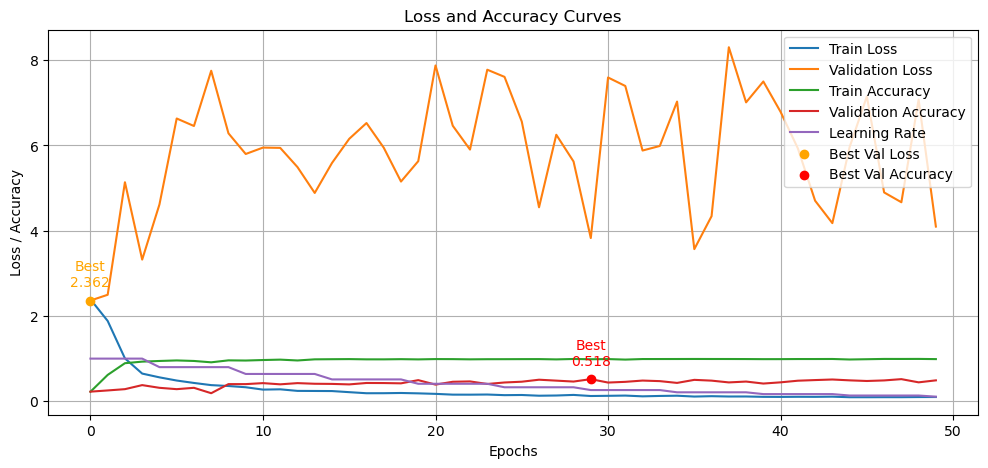

C:\Users\cathalert\AppData\Local\Temp\ipykernel_2712\46332981.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r'model_weights\model1_shuf

Train_loss=2.113; Train_accuracy=0.22 
 Validation_loss=2.349; Validation_accuracy=0.233 
Test_loss=2.308; Test_accuracy=0.25 



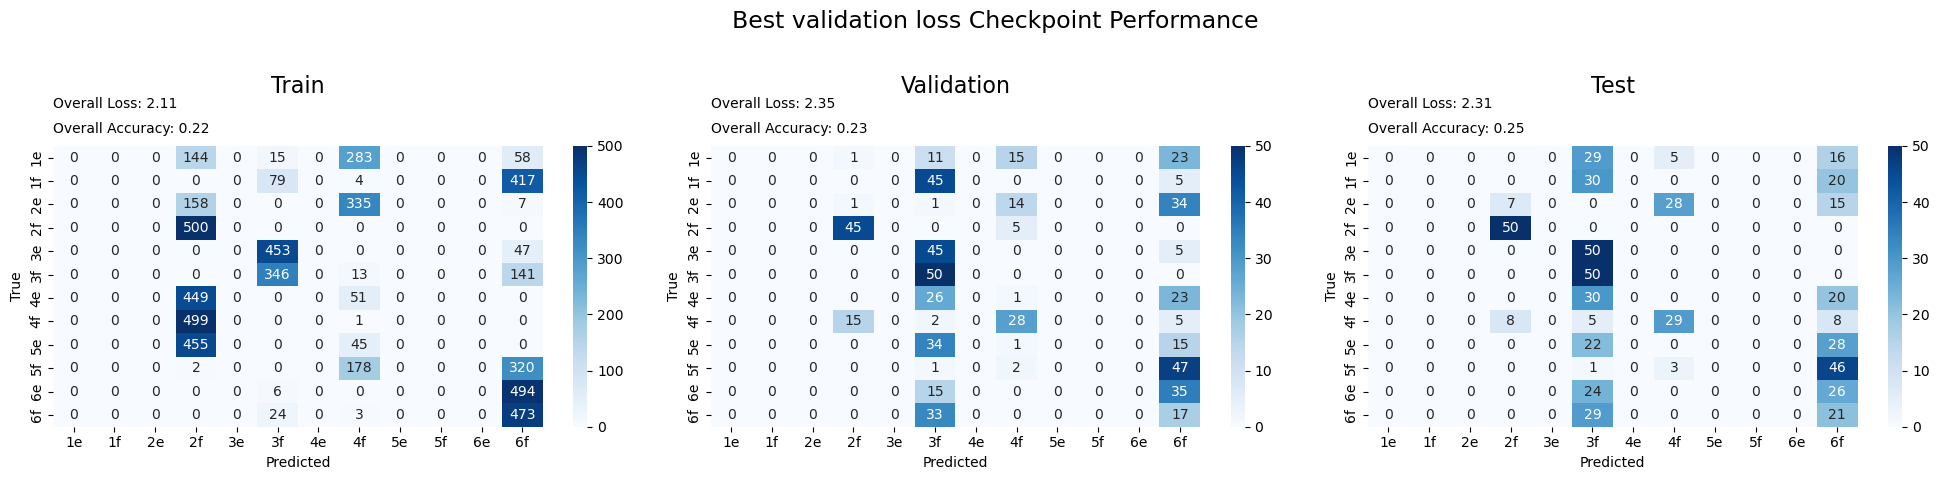

C:\Users\cathalert\AppData\Local\Temp\ipykernel_2712\46332981.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r'model_weights\model1_shuf

Train_loss=0.048; Train_accuracy=0.984 
 Validation_loss=3.787; Validation_accuracy=0.522 
Test_loss=2.986; Test_accuracy=0.583 



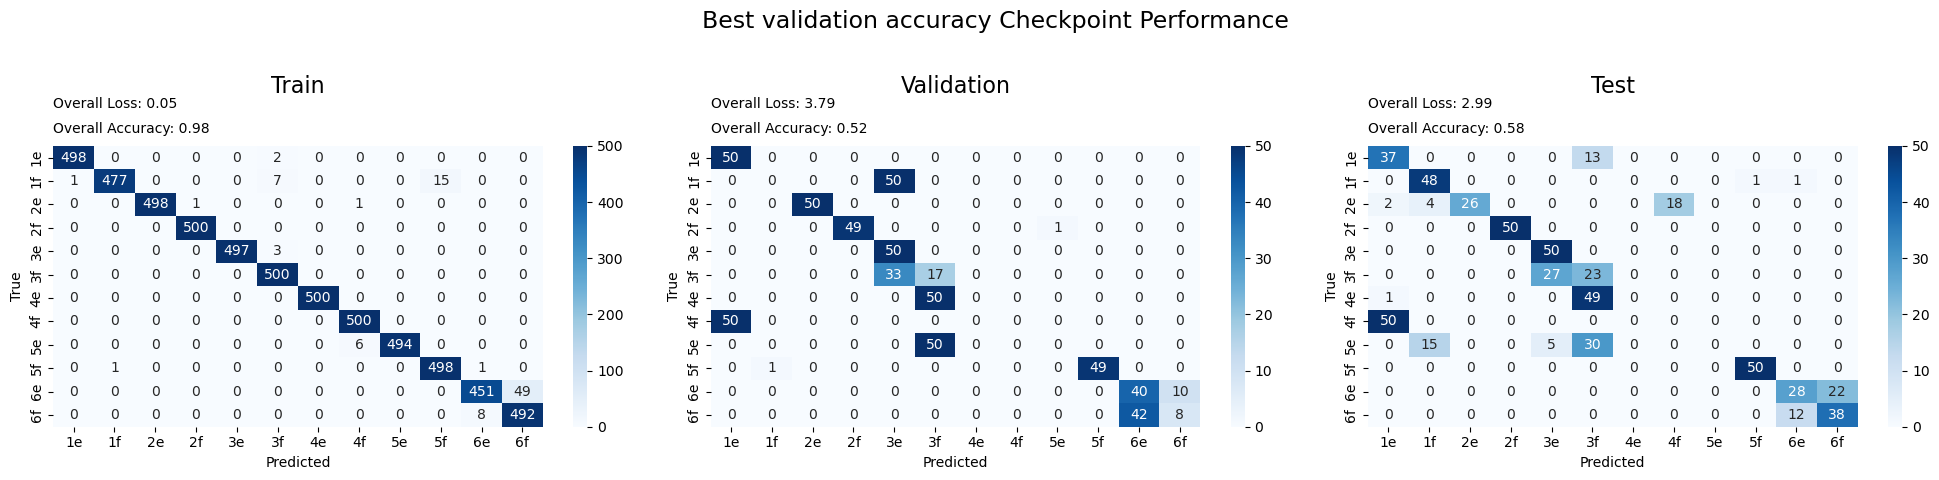

In [128]:

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.plot(train_loss_vec, label='Train Loss')
plt.plot(val_loss_vec, label='Validation Loss')
plt.plot(train_accuracy_vec, label='Train Accuracy')
plt.plot(val_accuracy_vec, label='Validation Accuracy')
plt.plot([n * 10000 for n in lr_vec], label='Learning Rate')

# Mark the best validation loss point
if len(val_loss_vec) > 0:
    best_epoch = np.argmin(val_loss_vec)
    plt.scatter(best_epoch, val_loss_vec[best_epoch], color='orange', zorder=5, label='Best Val Loss')
    plt.annotate(f'Best\n{val_loss_vec[best_epoch]:.3f}', 
                 (best_epoch, val_loss_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='orange')
# Mark the best validation accuracy point
if len(val_accuracy_vec) > 0:
    best_epoch = np.argmax(val_accuracy_vec)
    plt.scatter(best_epoch, val_accuracy_vec[best_epoch], color='red', zorder=5, label='Best Val Accuracy')
    plt.annotate(f'Best\n{val_accuracy_vec[best_epoch]:.3f}', 
                 (best_epoch, val_accuracy_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title('Loss and Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid()
plt.show()

labels = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']

#evaluate the model on the test set
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels)

# # load the last checkpoint
# last_chk = [f for f in os.listdir(r'model_weights\model1_shuffled') if f.startswith('last_cp_e')]
# last_chk.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))  # Sort by epoch number
# last_chk = last_chk[-1]  # Get the last checkpoint file
# net.load_state_dict(torch.load(fr'model_weights\model1_shuffled\{last_chk}'))
# net.eval()
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance' , shuffled=True)
# # check the best validation loss

# load the loss best model 
net.load_state_dict(torch.load(r'model_weights\model1_shuffled\best_val_loss_cp.pth'))
net.eval()
# evaluate
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation loss Checkpoint Performance' , shuffled=True)

# load the acc best model
net.load_state_dict(torch.load(r'model_weights\model1_shuffled\best_val_accuracy_cp.pth'))
net.eval()
# evaluate
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation accuracy Checkpoint Performance' , shuffled=True)


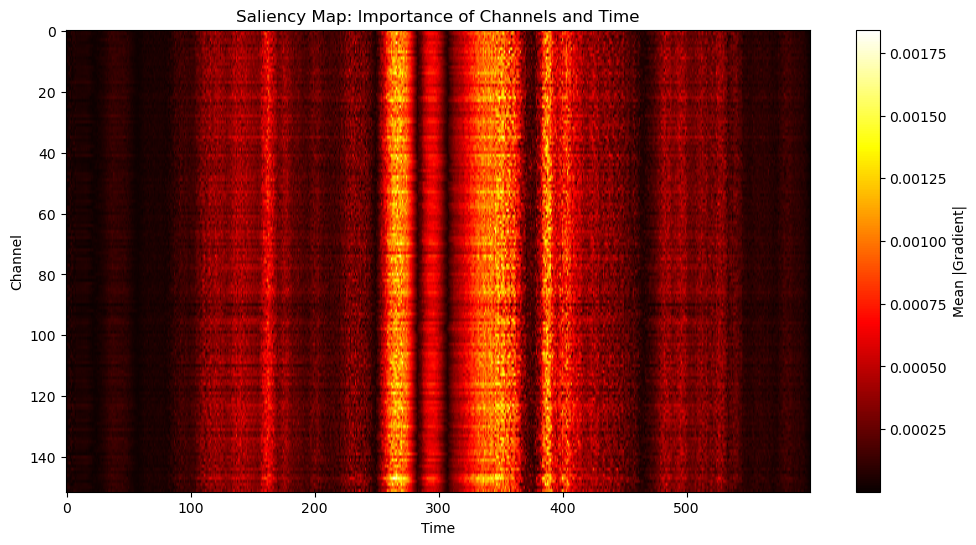

Top 10 most important channels (by mean gradient): [147  22  35  53  86 116  41 124  74  70]


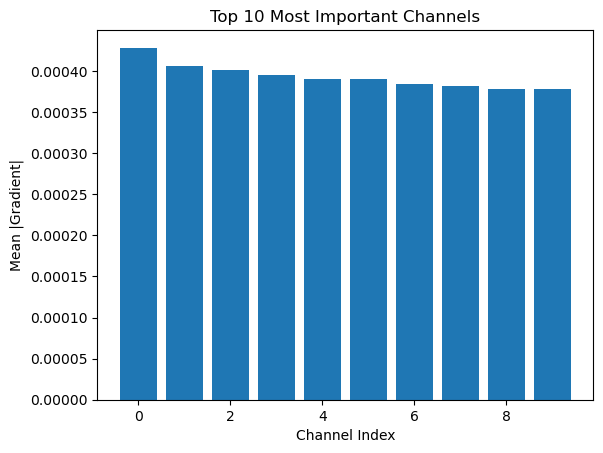

In [58]:
# latent space after each block
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

movement_list = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']

def get_latent_space(model, dataloader, device):
    model.eval()
    all_latents = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            # Get output after each block
            x0 = model.initial(X)
            x1 = model.res_blocks[0](x0)
            x2 = model.res_blocks[1](x1)
            x3 = model.res_blocks[2](x2)
            pooled0 = model.pool(x0).squeeze(-1).cpu().numpy()
            pooled1 = model.pool(x1).squeeze(-1).cpu().numpy()
            pooled2 = model.pool(x2).squeeze(-1).cpu().numpy()
            pooled3 = model.pool(x3).squeeze(-1).cpu().numpy()
            all_latents.append({
                'initial': pooled0,
                'block1': pooled1,
                'block2': pooled2,
                'block3': pooled3
            })
            all_labels.append(y.cpu().numpy())
    # Concatenate results
    latents = {
        'initial': np.concatenate([d['initial'] for d in all_latents], axis=0),
        'block1': np.concatenate([d['block1'] for d in all_latents], axis=0),
        'block2': np.concatenate([d['block2'] for d in all_latents], axis=0),
        'block3': np.concatenate([d['block3'] for d in all_latents], axis=0),
    }
    labels = np.concatenate(all_labels, axis=0)
    return latents, labels

# Get latent space

#load the best model
net.load_state_dict(torch.load(r'model_weights\model1_shuffled\best_val_accuracy_cp.pth'))
latents, labels = get_latent_space(net, dl_val, device)
# Perform PCA
pca = PCA(n_components=2)
pca_initial = pca.fit_transform(latents['initial'])
pca_block1 = pca.fit_transform(latents['block1'])
pca_block2 = pca.fit_transform(latents['block2'])
pca_block3 = pca.fit_transform(latents['block3'])
# Plot PCA results in 2d as subplots
plt.figure(figsize=(20, 10))
titles = ['Initial Conv', 'After Block 1', 'After Block 2', 'After Block 3']
pca_results = [pca_initial, pca_block1, pca_block2, pca_block3]

for i, (title, pca_data) in enumerate(zip(titles, pca_results)):
    plt.subplot(2, 2, i+1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Add legend
    handles = []
    for j, label in enumerate(movement_list):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=scatter.cmap(j/len(movement_list)), markersize=10))
    plt.legend(handles=handles, title='Movement', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')
    plt.grid()
plt.tight_layout()
plt.show()




C:\Users\cathalert\AppData\Local\Temp\ipykernel_2712\1698790887.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(r'model_weights\model1_sh

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights\\model1_shuffled\\best_val_accuracy_cp.pth'

# Gabby


# Check the desterbution of each monkey - based on latent space (last layer before classifier)


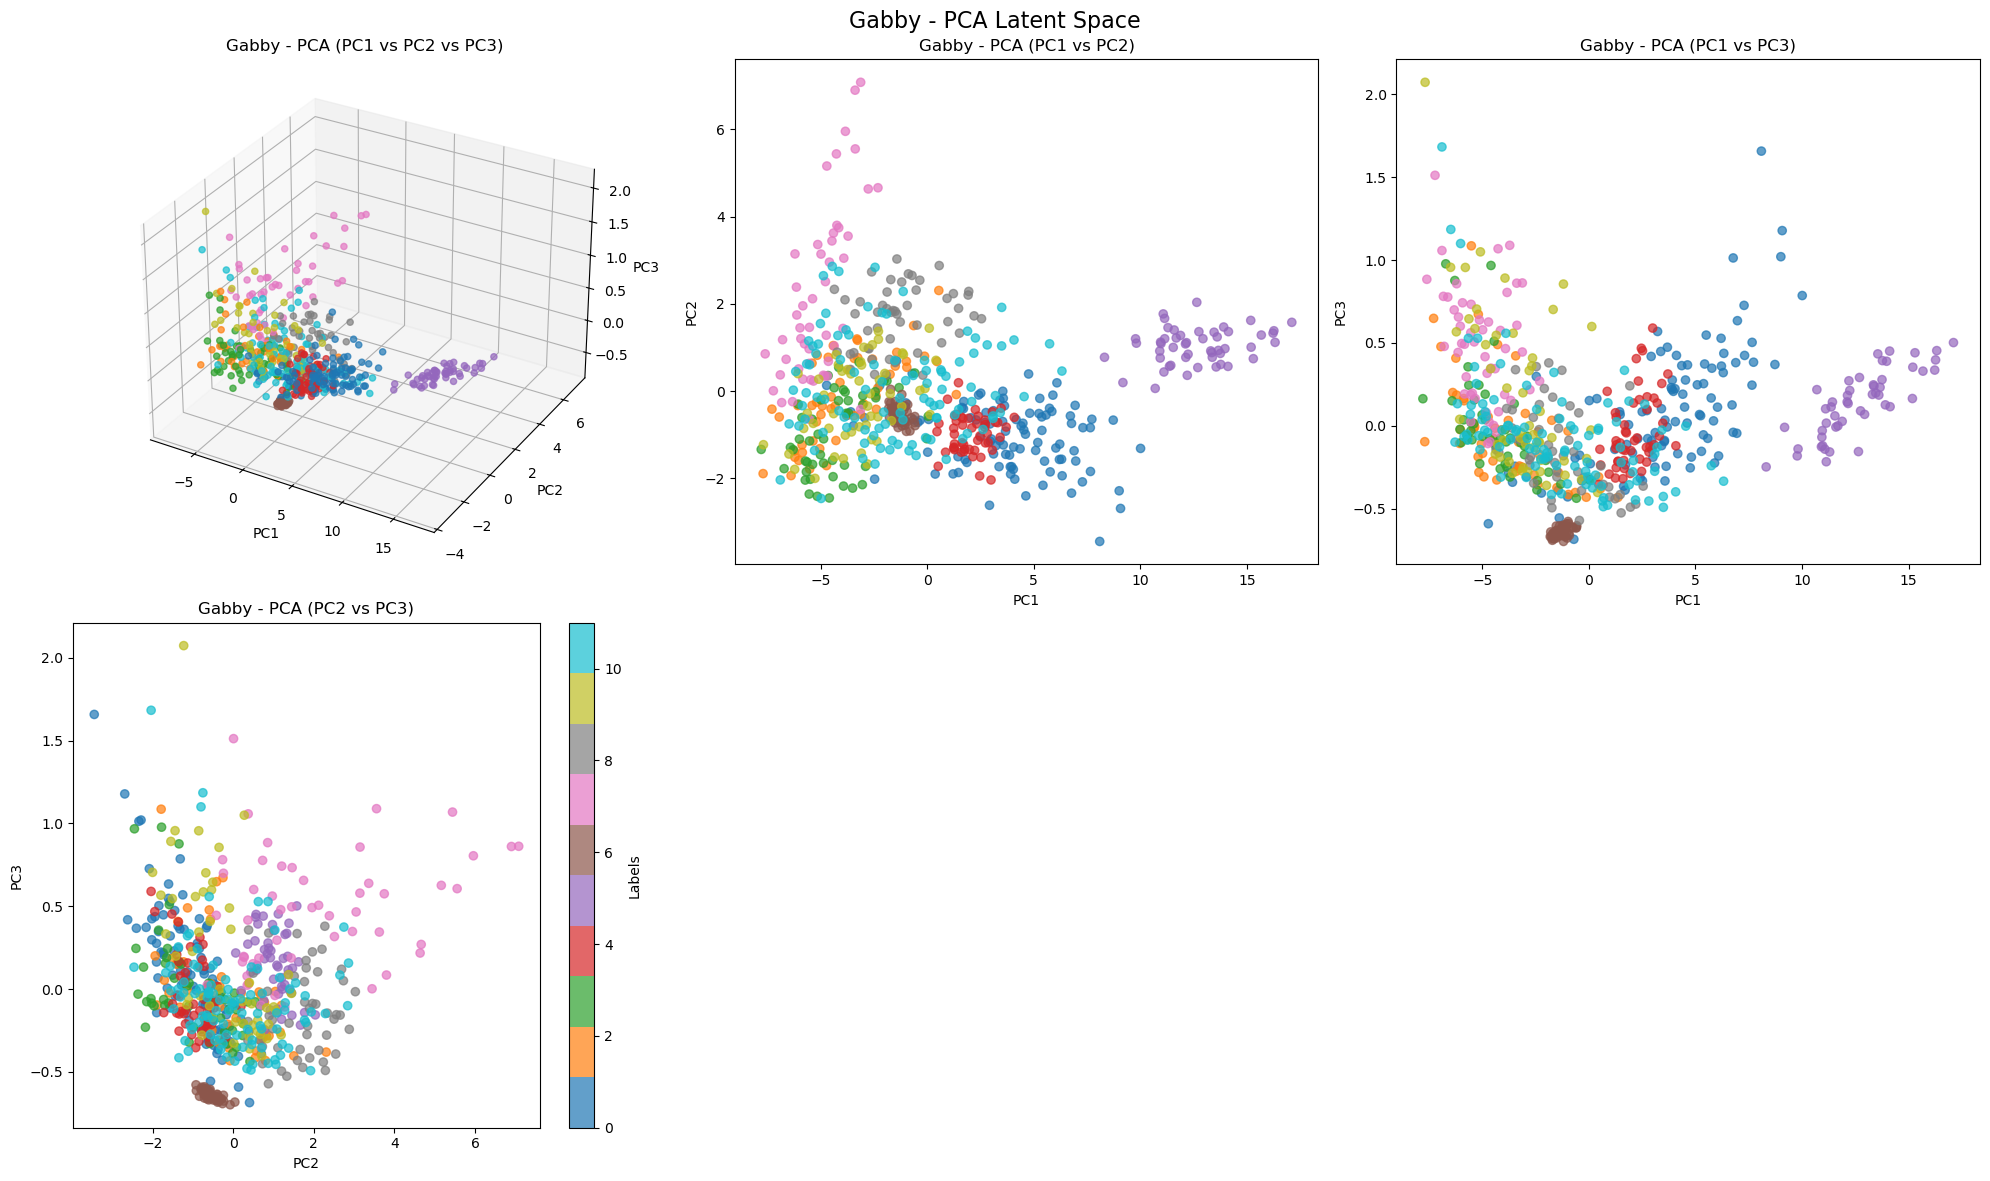

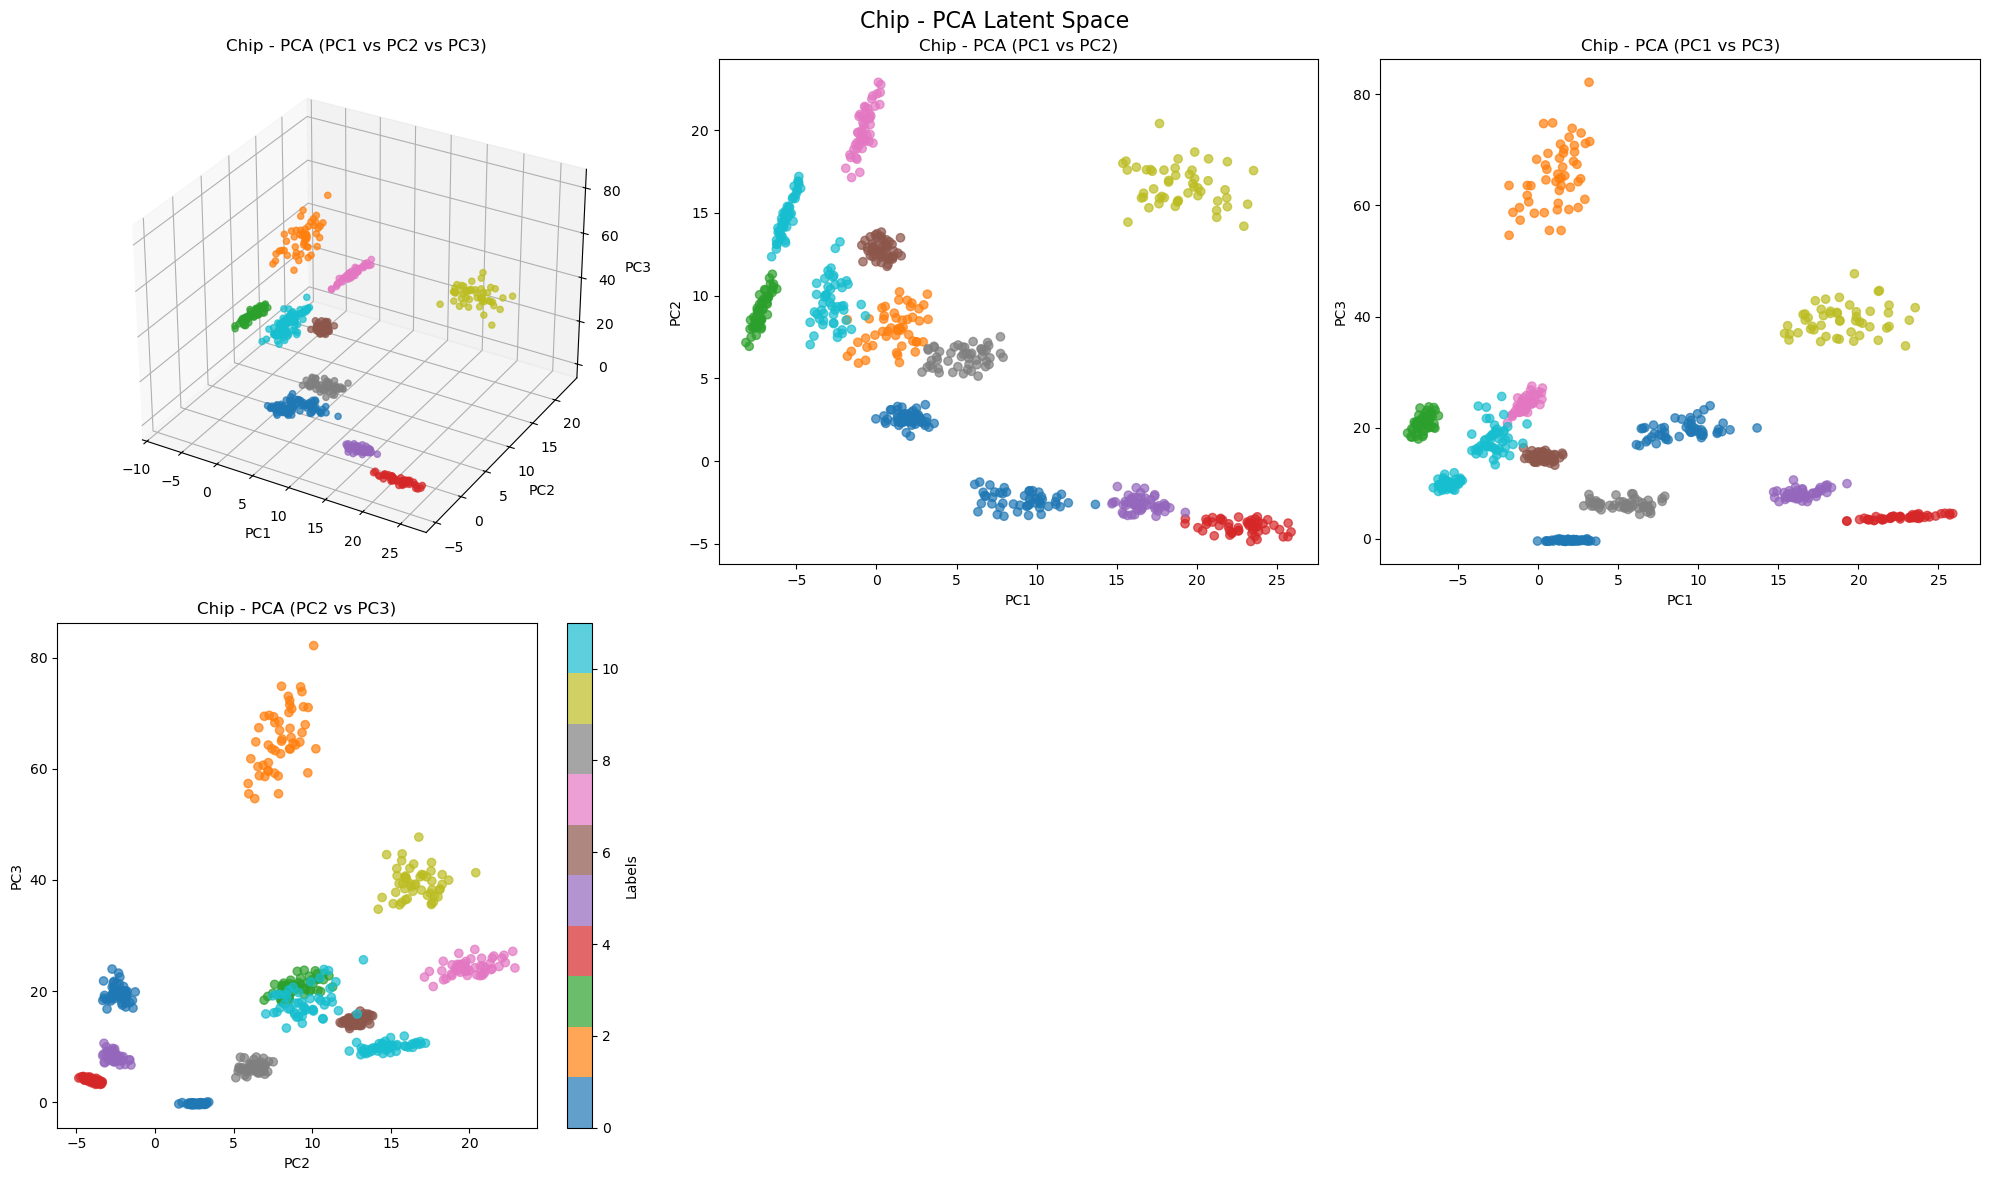

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D

# === Load Gabby dataset ===
x = np.load(r"dataset/Gabby/test/X_long.npy")
y = np.load(r"dataset/Gabby/test/y_long.npy")
x = x[:, :, 200:800]
x = np.transpose(x, (0, 2, 1))  # [samples, time, channels]
# randomly shuffle the channels on x - for each sample
for i in range(x.shape[0]):
    x[i] = x[i, np.random.permutation(x.shape[1]), :]
gabby_dataset = NeuronalDataset(x, y, transform=Ntransform())
# Assuming you already have `dl_gabby` ready like:
dl_gabby = DataLoader(gabby_dataset, batch_size=batch_size, num_workers=num_workers)

# === Extract latent space for Gabby ===
net.eval()
latent_space = []
labels = []

with torch.no_grad():
    for X, y in dl_gabby:
        X = X.to(device)
        latent_output = net.pool(net.res_blocks(net.initial(X))).squeeze(-1)
        latent_space.append(latent_output.cpu().numpy())
        labels.append(y.numpy())

latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate(labels, axis=0)

# === PCA on Gabby ===
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent_space)

# === Load Chip dataset ===
x = np.load(r"dataset/Chip/test/X_long.npy")
y = np.load(r"dataset/Chip/test/y_long.npy")
x = x[:, :, 200:800]
x = np.transpose(x, (0, 2, 1))  # [samples, time, channels]

chip_dataset = NeuronalDataset(x, y, transform=Ntransform())
dl_chip = DataLoader(chip_dataset, batch_size=64, num_workers=num_workers)

# === Extract latent space for Chip ===
latent_space_chip = []
labels_chip = []

with torch.no_grad():
    for X, y in dl_chip:
        X = X.to(device)
        latent_output = net.pool(net.res_blocks(net.initial(X))).squeeze(-1)
        latent_space_chip.append(latent_output.cpu().numpy())
        labels_chip.append(y.numpy())

latent_space_chip = np.concatenate(latent_space_chip, axis=0)
labels_chip = np.concatenate(labels_chip, axis=0)

# === Project Chip into Gabby PCA space ===
latent_pca_chip = pca.transform(latent_space_chip)

# === Plotting function ===
def plot_all_pca_combinations(latent_pca, labels, title_prefix):
    combs_3d = [(0, 1, 2)]
    combs_2d = list(combinations([0, 1, 2], 2))

    fig = plt.figure(figsize=(20, 12))

    # 3D Plot
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.scatter(latent_pca[:, 0], latent_pca[:, 1], latent_pca[:, 2],
                c=labels, cmap='tab10', alpha=0.7)
    ax1.set_title(f'{title_prefix} - PCA (PC1 vs PC2 vs PC3)')
    ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')

    # 2D Plots
    for i, (a, b) in enumerate(combs_2d):
        ax = fig.add_subplot(2, 3, i+2)
        sc = ax.scatter(latent_pca[:, a], latent_pca[:, b], c=labels, cmap='tab10', alpha=0.7)
        ax.set_title(f'{title_prefix} - PCA (PC{a+1} vs PC{b+1})')
        ax.set_xlabel(f'PC{a+1}')
        ax.set_ylabel(f'PC{b+1}')
    plt.colorbar(sc, ax=ax, label='Labels')
    plt.suptitle(f'{title_prefix} - PCA Latent Space', fontsize=16)
    plt.tight_layout()
    plt.show()

# === Plot Gabby ===
plot_all_pca_combinations(latent_pca, labels, title_prefix="Gabby")

# === Plot Chip ===
plot_all_pca_combinations(latent_pca_chip, labels_chip, title_prefix="Chip")
